In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [0]:
NDVI = pd.read_excel("./Used Datasets/NDvI2011-2020.xlsx", infer_datetime_format=True)
PET = pd.read_excel("./Used Datasets/pet_2010_2020_Scale0.1.xlsx", infer_datetime_format=True)
SolRad = pd.read_excel("./Used Datasets/Srad2010-20.xlsx")
AET = pd.read_excel("./Used Datasets/aet_2010_2020_Scale0.1.xlsx")
Tmin = pd.read_excel("./Used Datasets/tmin.xlsx")
Tmax = pd.read_excel("./Used Datasets/tmax.xlsx")
co2 = pd.read_csv("./Used Datasets/co2_trend_gl_re.txt", delim_whitespace=True)

In [0]:
PAR = np.array(SolRad.values[8 :, 1], dtype=int)*0.1*0.47
NdviArray = np.array(NDVI.values[: -10, 1], dtype=float)
Tavg = (np.array(Tmin.values[8 :, 1], dtype=float) + np.array(Tmax.values[8 :, 1], dtype=float))/20
CO2 = co2.values[:, 3]
W = 0.5 + (np.array(AET.values[17 :,1], dtype=int)/np.array(PET.values[17 :, 1], dtype=int))

In [0]:
W_new = np.zeros(W.size*2, dtype=float)
Tavg_new = np.zeros(Tavg.size*2, dtype=float)
PAR_new = np.zeros(PAR.size*2, dtype=float)
for i in range(Tavg.size):
    W_new[2*i] = W[i]
    Tavg_new[2*i] = Tavg[i]
    PAR_new[i*2] = PAR[i]
    if 2*(i+1)<Tavg_new.size:
        Tavg_new[2*i+1] = (Tavg[i]+Tavg[i+1])/2
        W_new[2*i+1] = (W[i]+W[i+1])/2
        PAR_new[2*i+1] = (PAR[i]+PAR[i+1])/2
Tavg_new[-1] = (Tavg_new[-24]+Tavg_new[-48])/2
W_new[-1] = (W_new[-24]+W_new[-48])/2
PAR_new[-1] = (PAR_new[-24]+PAR_new[-48])/2

W_new = np.zeros(W.size*2, dtype=float)
Tavg_new=np.zeros(Tavg.size*2, dtype=float)
PAR_new = np.zeros(PAR.size*2, dtype=float)
for i in range(Tavg.size):
    Tavg_new[2*i]=Tavg[i]
    Tavg_new[2*i+1]=Tavg[i]
    W_new[2*i] = W[i]
    W_new[2*i+1] = W[i]
    PAR_new[i*2] = PAR[i]
    PAR_new[i*2+1] = PAR[i]

In [0]:
Topt = Tavg_new[-6]
Tmon = Tavg_new
T1 = 0.8 + 0.02*Topt - 0.0005*Topt**2
T2 = 1.185/((1+np.exp(0.2*(Topt-10-Tmon)))*(1+np.exp(0.3*(-Topt-10+Tmon))))
LUE = 2.5*T1*T2*W_new
NPP = NdviArray*PAR_new*LUE
CO2_trend = co2.values[:, 4]

In [0]:
Tyear=np.zeros(8)
#Tmax1 = Tmax.values[8 :, 1]
for i in range(8):
    Tyear[i] = np.sum(Tavg_new[i*24 + 10 : i*24+34])/24
#Tyear[0] = np.sum(Tavg_new[: 10])/10

In [0]:
df_pr = NDVI.copy()
df_pr = df_pr.drop(index=df_pr.index[-10 :], columns='NDVI')
df_pr['NPP'] = NPP
df_pr.DateTime = pd.to_datetime(df_pr.DateTime, yearfirst=True)
df_pr = df_pr.set_index("DateTime")
df_pr = df_pr.reset_index()
df_pr.columns = ['ds','y']

In [0]:
#Validate our model using 2019 as reerence
train_data_pr = df_pr.iloc[:len(df_pr)-24]
test_data_pr = df_pr.iloc[len(df_pr)-24:]
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=24,freq="SMS")
prophet_pred = m.predict(future)
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-24:]['ds'], "Pred" : prophet_pred[-24:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "SMS"

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


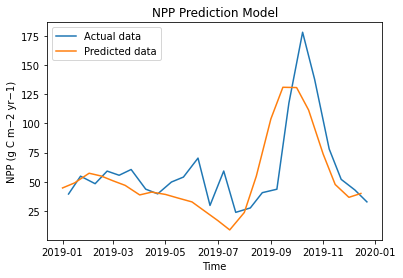

In [0]:
f = plt.figure(1)
ax = f.add_subplot(111)
ax.plot(test_data_pr['ds'], test_data_pr['y'].values, label="Actual data")
ax.plot(prophet_pred.index, prophet_pred['Pred'].values, label="Predicted data")
ax.set_ylabel('NPP (g C m−2 yr−1)')
ax.set_xlabel('Time')
ax.set_title('NPP Prediction Model')
ax.legend()

f.show()
f.savefig('NppModel.png', dpi=300)

In [0]:
#Predict data for 2020 & 2021
train_data_pr1 = df_pr.iloc[:]
m1 = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m1.fit(train_data_pr1)
future1 = m1.make_future_dataframe(periods=48,freq="SMS")
prophet_pred1 = m1.predict(future1)
prophet_pred1 = pd.DataFrame({"Date" : prophet_pred1[-48:]['ds'], "Pred" : prophet_pred1[-48:]["yhat"]})
prophet_pred1 = prophet_pred1.set_index("Date")
prophet_pred1.index.freq = "SMS"

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


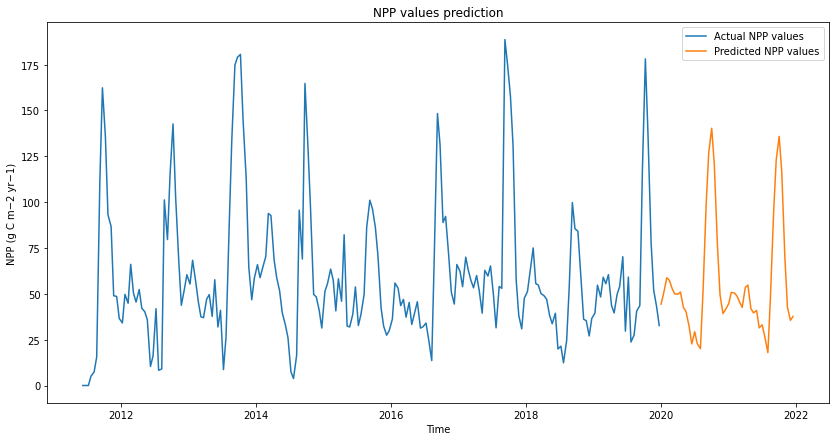

In [0]:
f1 = plt.figure(figsize=(14, 7))
ax1 = f1.add_subplot(111)
ax1.plot(train_data_pr1['ds'].values, train_data_pr1['y'].values, label="Actual NPP values")
ax1.plot(prophet_pred1.index, prophet_pred1['Pred'].values, label="Predicted NPP values")
ax1.set_ylabel('NPP (g C m−2 yr−1)')
ax1.set_xlabel('Time')
ax1.set_title('NPP values prediction')
ax1.legend()

f1.show()
f1.savefig('NppPrediction.png', dpi=300)

In [0]:
CO2 = co2.values[:,3]
co2_day=co2.values[:,2]
co2_month=co2.values[:,1]

CO2_avg = np.zeros(240-26, dtype=float)
sum=0
y=0
for c in range(CO2.size):
    if(co2_day[c]%31!=0):
        if(co2_month[c]!=2):
            sum+=CO2[c]
            if(co2_day[c]%15==0 and c!=0 ):
                CO2_avg[y]=sum/15
                sum=0
                y=y+1
        elif(co2_day[c]%29!=0):
            sum+=CO2[c]
            if(co2_day[c]%14==0  ):
                CO2_avg[y]=sum/14
                sum=0
                y=y+1
# CO2_avg[0]=391
CO2_avg = CO2_avg[: -8]

In [0]:
df = pd.DataFrame()
df['NPP']=NPP
df['CO2']=CO2_avg
df.corr(method='pearson', min_periods=12)

,NPP,CO2
NPP,1.000000,-0.117917
CO2,-0.117917,1.000000


In [53]:
df2 = pd.DataFrame()
df2['CO2']=CO2_avg
df2['Temp']=Tavg_new
df2.corr(method='spearman', min_periods=12)

,CO2,Temp
CO2,1.000000,0.066133
Temp,0.066133,1.000000


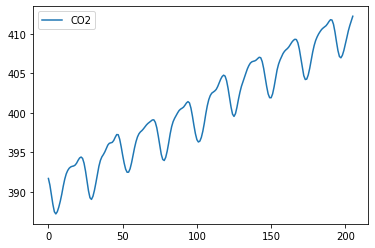

In [0]:
pt1 = plt.figure(3)
ax = pt1.add_subplot(111)
ax.plot(CO2_avg, label='CO2')
#ax.plot(NPP, label='NPP')
ax.legend()
pt1.show()